In [ ]:
!pip install -q pandas==2.2.2

In [ ]:
# Clone the repository
!git clone https://github.com/ensemble-core/NdLinear.git
%cd NdLinear

# Open the file and modify the required Python version.
# This uses sed to replace '>=3.12' with '>=3.11'
!sed -i 's/>=3\.12/>=3\.11/g' pyproject.toml

# Install the package
!pip install -q .

In [ ]:
!pip install datasets transformers

In [42]:
import torch
from ndlinear import NdLinear
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
from transformers import AutoTokenizer
from datasets import load_dataset
import math
import matplotlib.pyplot as plt

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.EMNIST(root='./data', split='digits', train=True, download=True, transform=transform)
test_dataset  = datasets.EMNIST(root='./data', split='digits', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)
num_classes = 10

Using device: cuda


100%|██████████| 562M/562M [00:13<00:00, 41.6MB/s]


In [22]:
class CNNWithLinear(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithLinear, self).__init__()
        # Two convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input: [batch,1,28,28] -> [batch,32,28,28]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # -> [batch,64,28,28]
        self.pool  = nn.MaxPool2d(2, 2)                          # reduces H and W by factor 2

        # After two poolings, image size becomes 28/2/2 = 7, so feature map shape: [batch, 64, 7, 7]
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # flatten then fully-connected
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 7, 7]
        x = x.view(x.size(0), -1)             # flatten to [batch, 64*7*7]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [23]:
class CNNWithNdLinear(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithNdLinear, self).__init__()
        # Same convolutional base
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        # Instead of flattening the conv output, apply NdLinear directly.
        # The conv output shape is [batch, 64, 7, 7]. We map it to a new multi-d tensor,
        # here chosen as shape (8, 4, 4) because 8 * 4 * 4 = 128. (This is analogous to mapping 3136 -> 128.)
        self.ndlinear = NdLinear(input_dims=(64, 7, 7), hidden_size=(8, 4, 4))
        # Final classifier: after NdLinear, the feature is flattened to 128 (8*4*4) and mapped to num_classes.
        self.fc = nn.Linear(8 * 4 * 4, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 7, 7]
        x = self.ndlinear(x)                  # transforms [batch, 64, 7, 7] -> [batch, 8, 4, 4]
        x = x.view(x.size(0), -1)             # flatten to [batch, 8*4*4 = 128]
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [24]:
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    model.train()
    total_time = 0.0
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
        epoch_time = time.time() - start_time
        total_time += epoch_time
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f} s")
    return total_time

In [25]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item() * data.size(0)
            preds = outputs.argmax(dim=1, keepdim=True)
            correct += preds.eq(target.view_as(preds)).sum().item()
    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

In [26]:
epochs = 10
lr = 0.001
criterion = nn.CrossEntropyLoss()

In [27]:
print("Training CNN with nn.Linear ...")
model_linear = CNNWithLinear(num_classes).to(device)
optimizer_linear = optim.Adam(model_linear.parameters(), lr=lr)
time_linear = train_model(model_linear, train_loader, criterion, optimizer_linear, device, epochs=epochs)
test_loss_linear, accuracy_linear = evaluate_model(model_linear, test_loader, criterion, device)
print("\nCNN with nn.Linear")
print(f"Total Training Time: {time_linear:.2f} s")
print(f"Test Loss: {test_loss_linear:.4f}")
print(f"Test Accuracy: {accuracy_linear*100:.2f}%")

Training CNN with nn.Linear ...
Epoch 1 - Loss: 0.0714, Time: 77.43 s
Epoch 2 - Loss: 0.0303, Time: 65.33 s
Epoch 3 - Loss: 0.0228, Time: 67.27 s
Epoch 4 - Loss: 0.0180, Time: 65.92 s
Epoch 5 - Loss: 0.0157, Time: 62.97 s
Epoch 6 - Loss: 0.0123, Time: 63.36 s
Epoch 7 - Loss: 0.0119, Time: 64.36 s
Epoch 8 - Loss: 0.0100, Time: 65.52 s
Epoch 9 - Loss: 0.0090, Time: 66.66 s
Epoch 10 - Loss: 0.0080, Time: 62.20 s

CNN with nn.Linear
Total Training Time: 661.01 s
Test Loss: 0.0207
Test Accuracy: 99.58%


In [28]:
print("\nTraining CNN with NdLinear ...")
model_ndlinear = CNNWithNdLinear(num_classes).to(device)
optimizer_ndlinear = optim.Adam(model_ndlinear.parameters(), lr=lr)

time_ndlinear = train_model(model_ndlinear, train_loader, criterion, optimizer_ndlinear, device, epochs=epochs)
test_loss_ndlinear, accuracy_ndlinear = evaluate_model(model_ndlinear, test_loader, criterion, device)
print("\nCNN with NdLinear")
print(f"Total Training Time: {time_ndlinear:.2f} s")
print(f"Test Loss: {test_loss_ndlinear:.4f}")
print(f"Test Accuracy: {accuracy_ndlinear*100:.2f}%")


Training CNN with NdLinear ...
Epoch 1 - Loss: 0.1754, Time: 64.85 s
Epoch 2 - Loss: 0.0724, Time: 65.66 s
Epoch 3 - Loss: 0.0577, Time: 65.42 s
Epoch 4 - Loss: 0.0501, Time: 66.10 s
Epoch 5 - Loss: 0.0460, Time: 65.76 s
Epoch 6 - Loss: 0.0424, Time: 66.11 s
Epoch 7 - Loss: 0.0396, Time: 66.80 s
Epoch 8 - Loss: 0.0371, Time: 64.44 s
Epoch 9 - Loss: 0.0353, Time: 65.44 s
Epoch 10 - Loss: 0.0336, Time: 67.97 s

CNN with NdLinear
Total Training Time: 658.55 s
Test Loss: 0.0219
Test Accuracy: 99.36%


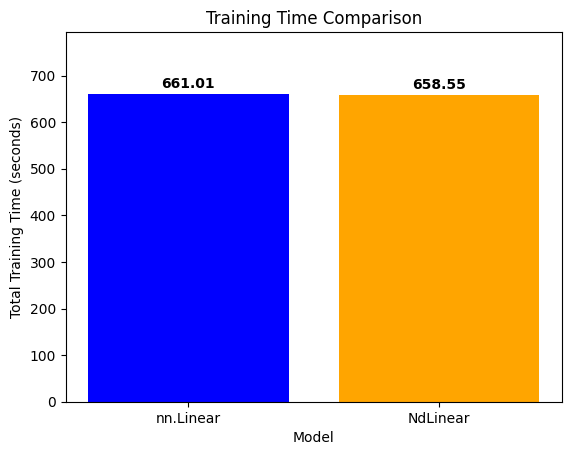

In [29]:
# Data for comparison
models = ['nn.Linear', 'NdLinear']
training_times = [time_linear, time_ndlinear]
accuracies = [accuracy_linear * 100, accuracy_ndlinear * 100]  # convert to percentage

# Plot 1: Training Time Comparison
plt.figure()
plt.bar(models, training_times, color=['blue', 'orange'])
plt.title('Training Time Comparison')
plt.ylabel('Total Training Time (seconds)')
plt.xlabel('Model')
plt.ylim(0, max(training_times)*1.2)
for i, v in enumerate(training_times):
    plt.text(i, v + max(training_times)*0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

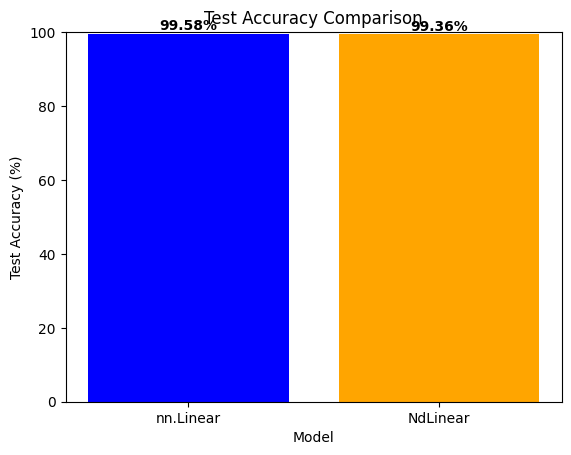

In [30]:
# Plot 2: Test Accuracy Comparison
plt.figure()
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('Model')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

In [31]:
print("\nComparison:")
print(f"Time Difference: NdLinear model training time is {time_ndlinear - time_linear:.2f} s " +
      ("slower" if time_ndlinear > time_linear else "faster") + " than the Linear model.")
print(f"Accuracy Difference: NdLinear model accuracy is {accuracy_ndlinear*100 - accuracy_linear*100:.2f}% " +
      ("higher" if accuracy_ndlinear > accuracy_linear else "lower") + " than the Linear model.")


Comparison:
Time Difference: NdLinear model training time is -2.46 s faster than the Linear model.
Accuracy Difference: NdLinear model accuracy is -0.22% lower than the Linear model.


In [32]:
dataset = load_dataset("ag_news")
train_subset = dataset["train"].shuffle(seed=42).select(range(1000))
test_subset  = dataset["test"].shuffle(seed=42).select(range(200))
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
max_length = 32

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [33]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=max_length)


train_tokenized = train_subset.map(tokenize_function, batched=True)
test_tokenized  = test_subset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [34]:
# Define a PyTorch dataset wrapper
class TextDataset(Dataset):
    def __init__(self, tokenized_dataset):
        self.input_ids = tokenized_dataset["input_ids"]
        self.attention_mask = tokenized_dataset["attention_mask"]
        self.labels = tokenized_dataset["label"]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [35]:
train_data = TextDataset(train_tokenized)
test_data  = TextDataset(test_tokenized)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32)
vocab_size = tokenizer.vocab_size
num_classes = 4  # AG News has 4 classes

In [36]:
# Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

In [37]:
# Custom Transformer Encoder Layer that optionally uses NdLinear in feed-forward layers
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1, use_ndlinear=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        if use_ndlinear:
            # When input dims are one-dimensional, NdLinear acts as nn.Linear.
            self.linear1 = NdLinear(input_dims=(d_model,), hidden_size=(dim_feedforward,))
            self.linear2 = NdLinear(input_dims=(dim_feedforward,), hidden_size=(d_model,))
        else:
            self.linear1 = nn.Linear(d_model, dim_feedforward)
            self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # src shape: (seq_len, batch, d_model)
        attn_output, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.activation(self.linear1(src)))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src

In [38]:
# Transformer Classifier that stacks multiple encoder layers
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2,
                 dim_feedforward=256, dropout=0.1, max_length=32, num_classes=4, use_ndlinear=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_length)
        # Create encoder layers
        self.layers = nn.ModuleList([
            CustomTransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, use_ndlinear)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        # Use simple average pooling for classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # input_ids shape: (batch, seq_len)
        embedded = self.embedding(input_ids)  # (batch, seq_len, d_model)
        embedded = self.pos_encoder(embedded)
        # Transformer encoder expects shape (seq_len, batch, d_model)
        src = embedded.transpose(0, 1)
        for layer in self.layers:
            src = layer(src)
        # Transpose back: (batch, seq_len, d_model)
        encoded = src.transpose(0, 1)
        # Pool across sequence dimension (mean pooling)
        pooled = encoded.mean(dim=1)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

In [39]:
def train_model(model, loader, criterion, optimizer, device, epochs=2):
    model.train()
    total_time = 0.0
    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_ids.size(0)
        epoch_time = time.time() - start_time
        total_time += epoch_time
        avg_loss = running_loss / len(loader.dataset)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")
    return total_time

In [40]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * input_ids.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

In [43]:
print("Training TransformerClassifier with standard nn.Linear...")
model_standard = TransformerClassifier(vocab_size, num_classes=num_classes, use_ndlinear=False).to(device)
optimizer_standard = torch.optim.Adam(model_standard.parameters(), lr=lr)
time_standard = train_model(model_standard, train_loader, criterion, optimizer_standard, device, epochs=epochs)
loss_standard, acc_standard = evaluate_model(model_standard, test_loader, criterion, device)
print("\nStandard Model:")
print(f"Training Time: {time_standard:.2f}s, Test Loss: {loss_standard:.4f}, Test Accuracy: {acc_standard*100:.2f}%")

Training TransformerClassifier with standard nn.Linear...
Epoch 1 - Loss: 1.3876, Time: 0.59s
Epoch 2 - Loss: 1.1687, Time: 0.26s
Epoch 3 - Loss: 0.8664, Time: 0.26s
Epoch 4 - Loss: 0.5990, Time: 0.26s
Epoch 5 - Loss: 0.3333, Time: 0.27s
Epoch 6 - Loss: 0.1392, Time: 0.27s
Epoch 7 - Loss: 0.0477, Time: 0.26s
Epoch 8 - Loss: 0.0290, Time: 0.26s
Epoch 9 - Loss: 0.0084, Time: 0.27s
Epoch 10 - Loss: 0.0032, Time: 0.26s

Standard Model:
Training Time: 2.97s, Test Loss: 1.9700, Test Accuracy: 59.50%


In [44]:
print("\nTraining TransformerClassifier with NdLinear...")
model_ndlinear = TransformerClassifier(vocab_size, num_classes=num_classes, use_ndlinear=True).to(device)
optimizer_ndlinear = torch.optim.Adam(model_ndlinear.parameters(), lr=lr)
time_ndlinear = train_model(model_ndlinear, train_loader, criterion, optimizer_ndlinear, device, epochs=epochs)
loss_ndlinear, acc_ndlinear = evaluate_model(model_ndlinear, test_loader, criterion, device)
print("\nNdLinear Model:")
print(f"Training Time: {time_ndlinear:.2f}s, Test Loss: {loss_ndlinear:.4f}, Test Accuracy: {acc_ndlinear*100:.2f}%")


Training TransformerClassifier with NdLinear...
Epoch 1 - Loss: 1.3935, Time: 0.27s
Epoch 2 - Loss: 1.1929, Time: 0.27s
Epoch 3 - Loss: 0.8573, Time: 0.28s
Epoch 4 - Loss: 0.5638, Time: 0.27s
Epoch 5 - Loss: 0.2656, Time: 0.27s
Epoch 6 - Loss: 0.1148, Time: 0.28s
Epoch 7 - Loss: 0.1228, Time: 0.26s
Epoch 8 - Loss: 0.0783, Time: 0.27s
Epoch 9 - Loss: 0.0320, Time: 0.28s
Epoch 10 - Loss: 0.0591, Time: 0.28s

NdLinear Model:
Training Time: 2.72s, Test Loss: 2.0941, Test Accuracy: 58.00%


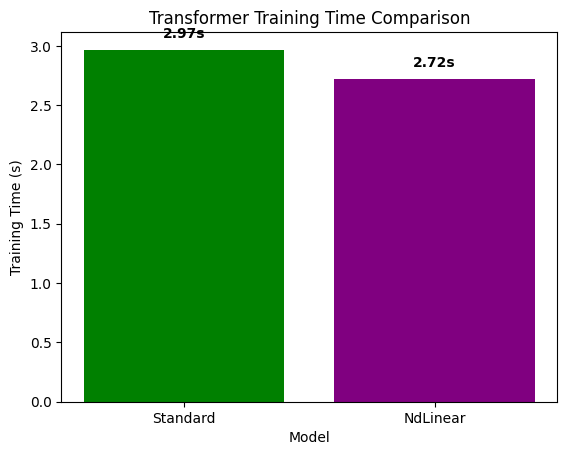

In [45]:
models = ['Standard', 'NdLinear']
times = [time_standard, time_ndlinear]
accuracies = [acc_standard * 100, acc_ndlinear * 100]  # in %
# Training Time Comparison Plot
plt.figure()
plt.bar(models, times, color=['green', 'purple'])
plt.title('Transformer Training Time Comparison')
plt.ylabel('Training Time (s)')
plt.xlabel('Model')
for i, v in enumerate(times):
    plt.text(i, v + 0.1, f"{v:.2f}s", ha='center', fontweight='bold')
plt.show()

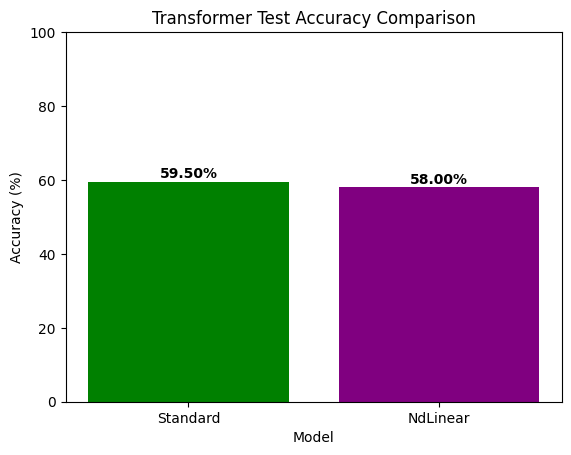

In [46]:
# Test Accuracy Comparison Plot
plt.figure()
plt.bar(models, accuracies, color=['green', 'purple'])
plt.title('Transformer Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

In [50]:
# Print comparison summary
print("\nComparison Summary:")
print(f"Time Difference: NdLinear model training time is {abs(time_ndlinear - time_standard):.2f}s " +
      ("slower" if time_ndlinear > time_standard else "faster") + " than the standard model.")
print(f"Accuracy Difference: NdLinear model accuracy is {abs(acc_ndlinear - acc_standard)*100:.2f}% " +
      ("higher" if acc_ndlinear > acc_standard else "lower") + " than the standard model.")


Comparison Summary:
Time Difference: NdLinear model training time is 0.24s faster than the standard model.
Accuracy Difference: NdLinear model accuracy is 1.50% lower than the standard model.
